IMPLEMENTING DEEP Q-NETWORK-BASED INVENTORY CONTROL IN A BIOCHEMICAL MANUFACTURING FACILITY.


Customer Demand Creation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random 
from collections import namedtuple, deque 
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

np.random.seed(0)
demand_hist = []
for i in range(52):
    for j in range(4):
        random_demand = np.random.normal(3, 1.5)
        if random_demand < 0:
            random_demand = 0
        random_demand = np.round(random_demand)
        demand_hist.append(random_demand)
    random_demand = np.random.normal(6, 1)
    if random_demand < 0:
        random_demand = 0
    random_demand = np.round(random_demand)
    demand_hist.append(random_demand)
    for j in range(2):
        random_demand = np.random.normal(12, 2)
        if random_demand < 0:
            random_demand = 0
        random_demand = np.round(random_demand)
        demand_hist.append(random_demand)
plt.hist(demand_hist)

: 

PyGame Initialization

In [ ]:
import pygame
# Constants
WIDTH = 1200
HEIGHT = 700
FPS = 60

# Colors
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)
BLUE = (0, 0, 255)
GREEN = (0, 255, 0)
RED = (255, 0, 0)

# Initialize Pygame
pygame.init()
pygame.font.init()
font = pygame.font.SysFont("Arial", 18)

# Create the game window
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("RL Warehouse Environment")
clock = pygame.time.Clock()

Defining the RL Environment

In [2]:
import torch
import numpy as np

class InvOptEnv():
    def __init__(self, demand_records):
        self.n_period = len(demand_records)
        self.current_period = 1
        self.day_of_week = 0
        self.inv_level = 25
        self.inv_pos = 25
        self.capacity = 50
        self.holding_cost = 3
        self.unit_price = 30
        self.fixed_order_cost = 50
        self.variable_order_cost = 10
        self.lead_time = 2
        self.order_arrival_list = []
        self.demand_list = demand_records
        self.state = np.array([self.inv_pos] + self.convert_day_of_week(self.day_of_week))
        self.state_list = []
        self.state_list.append(self.state)
        self.action_list = []
        self.reward_list = []
            
    def reset(self):
        self.state_list = []
        self.action_list = []
        self.reward_list = []
        self.inv_level = 25
        self.inv_pos = 25
        self.current_period = 1
        self.day_of_week = 0
        self.state = np.array([self.inv_pos] + self.convert_day_of_week(self.day_of_week))
        self.state_list.append(self.state)
        self.order_arrival_list = []
        return self.state
        
    def step(self, action):
        if action > 0:
            y = 1
            self.order_arrival_list.append([self.current_period+self.lead_time, action])
        else:
            y = 0
        if len(self.order_arrival_list) > 0:
            if self.current_period == self.order_arrival_list[0][0]:
                self.inv_level = min(self.capacity, self.inv_level + self.order_arrival_list[0][1])
                self.order_arrival_list.pop(0)  
        demand = self.demand_list[self.current_period-1]
        units_sold = demand if demand <= self.inv_level else self.inv_level
        reward = units_sold*self.unit_price-self.holding_cost*self.inv_level - y*self.fixed_order_cost \
                 -action*self.variable_order_cost    
        self.inv_level = max(0,self.inv_level-demand)
        self.inv_pos = self.inv_level
        if len(self.order_arrival_list) > 0:
            for i in range(len(self.order_arrival_list)):
                self.inv_pos += self.order_arrival_list[i][1]
        self.day_of_week = (self.day_of_week+1)%7
        self.state = np.array([self.inv_pos] +self.convert_day_of_week(self.day_of_week))
        self.current_period += 1
        self.state_list.append(self.state)
        self.action_list.append(action)
        self.reward_list.append(reward)
        if self.current_period > self.n_period:
            terminate = True
        else: 
            terminate = False
        return self.state, reward, terminate
        def render(self, action, reward, checkpoint_name):
        font = pygame.font.Font(None, 36)  # Define font here

        screen.fill(WHITE)
        pygame.draw.rect(screen, BLACK, (50, 50, 700*1.5, 300*1.5), 2)

        # Render inventory level
        inventory_boxes = int(self.inv_level)
        inventory_text = font.render("Inventory Level: ", True, BLACK)
        screen.blit(inventory_text, (60, 60))
        for i in range(inventory_boxes):
            pygame.draw.rect(screen, BLUE, (60 + i * 20, 90, 15, 30))
        inventory_value = font.render(str(self.inv_level), True, BLACK)
        screen.blit(inventory_value, (60 + inventory_boxes * 20, 95))

        # Render inventory position
        position_boxes = int(self.inv_pos)
        inventory_position_text = font.render("Inventory Position: ", True, BLACK)
        screen.blit(inventory_position_text, (60, 130))
        for i in range(position_boxes):
            pygame.draw.rect(screen, GREEN, (60 + i * 20, 160, 15, 30))
        position_value = font.render(str(self.inv_pos), True, BLACK)
        screen.blit(position_value, (60 + position_boxes * 20, 165))

        # Render demand
        if self.current_period - 1 < len(self.demand_list):
            demand_text = font.render("Demand: {}".format(self.demand_list[self.current_period - 1]), True, BLACK)
            screen.blit(demand_text, (60, 200))

        # Draw the action text
        action_text = font.render(f"Action: {action}", 1, (10, 10, 10))
        screen.blit(action_text, (60, 270))

        # Draw the reward text
        reward_text = font.render(f"Reward: {reward}", 1, (10, 10, 10))
        screen.blit(reward_text, (60, 340))

        # Draw the checkpoint name
        checkpoint_text = font.render(f"Checkpoint: {checkpoint_name}", 1, (10, 10, 10))
        screen.blit(checkpoint_text, (60, 410))

        pygame.display.flip()
    
    def convert_day_of_week(self,d):
        if d == 0:
            return [0, 0, 0, 0, 0, 0]
        if d == 1:
            return [1, 0, 0, 0, 0, 0] 
        if d == 2:
            return [0, 1, 0, 0, 0, 0] 
        if d == 3:
            return [0, 0, 1, 0, 0, 0] 
        if d == 4:
            return [0, 0, 0, 1, 0, 0] 
        if d == 5:
            return [0, 0, 0, 0, 1, 0] 
        if d == 6:
            return [0, 0, 0, 0, 0, 1] 

DQN Algorithm

In [3]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_unit=128, fc2_unit = 128):
        super(QNetwork,self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1= nn.Linear(state_size,fc1_unit)
        self.fc2 = nn.Linear(fc1_unit,fc2_unit)
        self.fc3 = nn.Linear(fc2_unit,action_size)
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


Set of Hyperparameters tested 1

episode1: -38720.0
episode2: -39297.0
episode3: -39665.0
episode4: -38965.0
episode5: -37161.0
episode6: -38681.0
episode7: -38964.0
episode8: -35576.0
episode9: -39322.0
episode10: -38383.0
episode11: -38443.0
episode12: -35245.0
episode13: -32551.0
episode14: -34328.0
episode15: -34216.0
episode16: -32915.0
episode17: -36400.0
episode18: -37737.0
episode19: -31641.0
episode20: -33514.0
episode21: -30867.0
episode22: -28927.0
episode23: -31351.0
episode24: -30132.0
episode25: -29761.0
episode26: -34148.0
episode27: -29732.0
episode28: -28462.0
episode29: -27785.0
episode30: -26290.0
episode31: -27382.0
episode32: -29313.0
episode33: -28532.0
episode34: -28996.0
episode35: -23861.0
episode36: -31291.0
episode37: -24976.0
episode38: -25043.0
episode39: -26186.0
episode40: -20528.0
episode41: -22127.0
episode42: -24674.0
episode43: -26842.0
episode44: -18775.0
episode45: -28126.0
episode46: -21216.0
episode47: -19302.0
episode48: -21206.0
episode49: -22300.0
episode50: -17862.0
episode51

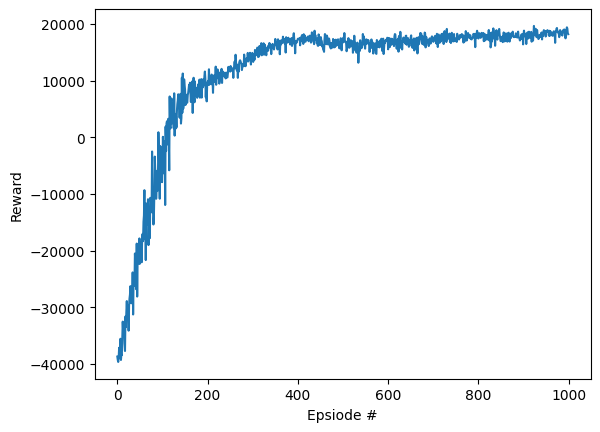

In [9]:
# Defining the Hyperparameters
BUFFER_SIZE = int(3*1e5)
BATCH_SIZE = 256
GAMMA = 0.90
TAU = 1e-3
LR = 4e-3
UPDATE_EVERY = 25

class Agent():    
    def __init__(self, state_size, action_size, seed):        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)        
        #Q- Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(),lr=LR)
        
        # Replay memory 
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE,BATCH_SIZE,seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
        
    def step(self, state, action, reward, next_step, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_step, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step+1)% UPDATE_EVERY
        if self.t_step == 0:
            if len(self.memory)>BATCH_SIZE:
                experience = self.memory.sample()
                self.learn(experience, GAMMA)
        
    def act(self, state, eps = 0):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        #Epsilon -greedy action selction
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
            
    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences
        criterion = torch.nn.MSELoss()
        self.qnetwork_local.train()
        self.qnetwork_target.eval()
        
        predicted_targets = self.qnetwork_local(states).gather(1,actions)
        with torch.no_grad():
            labels_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        labels = rewards + (gamma* labels_next*(1-dones))
        loss = criterion(predicted_targets,labels).to(device)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network #
        self.soft_update(self.qnetwork_local,self.qnetwork_target,TAU)
            
    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1-tau)*target_param.data)
            
class ReplayBuffer:
    
    def __init__(self, action_size, buffer_size, batch_size, seed):        
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experiences = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        
    def add(self,state, action, reward, next_state,done):
        e = self.experiences(state,action,reward,next_state,done)
        self.memory.append(e)
        
    def sample(self):
    
        experiences = random.sample(self.memory,k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        return (states,actions,rewards,next_states,dones)
    
    def __len__(self):
        return len(self.memory)

agent = Agent(state_size=7,action_size=21,seed=0)

def dqn(env, n_episodes= 1000, max_t = 10000, eps_start=1.0, eps_end = 0.01, eps_decay=0.995):
    scores = []
    eps = eps_start
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state,eps)
            next_state,reward,done = env.step(action)
            agent.step(state,action,reward,next_state,done)
            state = next_state
            score += reward
            if done:
                print('episode'+str(i_episode)+':', score)
                scores.append(score)
                break
        eps = max(eps*eps_decay,eps_end)## decrease the epsilon
    return scores

env = InvOptEnv(demand_hist)
scores= dqn(env)

plt.plot(np.arange(len(scores)),scores)
plt.ylabel('Reward')
plt.xlabel('Epsiode #')
plt.show()

Set of HyperParameters Tested 2

episode1: -37706.0
episode2: -35151.0
episode3: -28018.0
episode4: -13155.0
episode5: -9936.0
episode6: -1923.0
episode7: 2225.0
episode8: 2523.0
episode9: 4621.0
episode10: 8552.0
episode11: 10362.0
episode12: 8618.0
episode13: 7475.0
episode14: 7340.0
episode15: 6410.0
episode16: 6401.0
episode17: 5505.0
episode18: 7008.0
episode19: 5416.0
episode20: 4248.0
episode21: 3636.0
episode22: 3526.0
episode23: 3592.0
episode24: 3543.0
episode25: 3805.0
episode26: 2977.0
episode27: 2498.0
episode28: 3934.0
episode29: 2998.0
episode30: 2481.0
episode31: 2133.0
episode32: 1970.0
episode33: 1088.0
episode34: 903.0
episode35: 1738.0
episode36: 1615.0
episode37: 1628.0
episode38: 764.0
episode39: 905.0
episode40: 678.0
episode41: 712.0
episode42: 1371.0
episode43: 814.0
episode44: 525.0
episode45: 673.0
episode46: 950.0
episode47: 683.0
episode48: 750.0
episode49: 803.0
episode50: 775.0
episode51: 1196.0
episode52: 1036.0
episode53: 852.0
episode54: 1052.0
episode55: 871.0
episode56: 733.0
episod

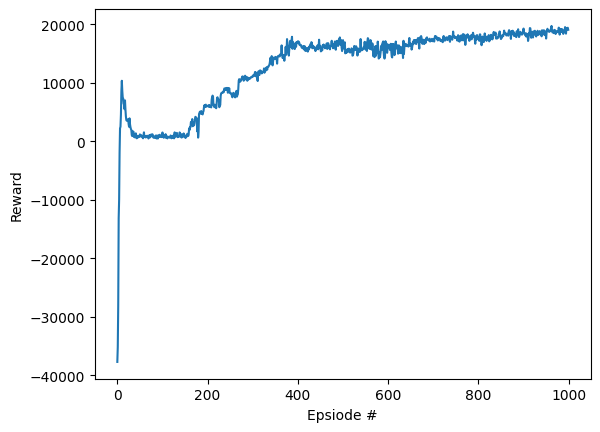

In [10]:
# Defining the Hyperparameters
BUFFER_SIZE = int(2*1e5)
BATCH_SIZE = 256
GAMMA = 0.90
TAU = 1e-3
LR = 4e-4
UPDATE_EVERY = 20

class Agent():    
    def __init__(self, state_size, action_size, seed):        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)        
        #Q- Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(),lr=LR)
        
        # Replay memory 
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE,BATCH_SIZE,seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
        
    def step(self, state, action, reward, next_step, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_step, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step+1)% UPDATE_EVERY
        if self.t_step == 0:
            if len(self.memory)>BATCH_SIZE:
                experience = self.memory.sample()
                self.learn(experience, GAMMA)
        
    def act(self, state, eps = 0):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        #Epsilon -greedy action selction
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
            
    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences
        criterion = torch.nn.MSELoss()
        self.qnetwork_local.train()
        self.qnetwork_target.eval()
        
        predicted_targets = self.qnetwork_local(states).gather(1,actions)
        with torch.no_grad():
            labels_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        labels = rewards + (gamma* labels_next*(1-dones))
        loss = criterion(predicted_targets,labels).to(device)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network #
        self.soft_update(self.qnetwork_local,self.qnetwork_target,TAU)
            
    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1-tau)*target_param.data)
            
class ReplayBuffer:
    
    def __init__(self, action_size, buffer_size, batch_size, seed):        
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experiences = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        
    def add(self,state, action, reward, next_state,done):
        e = self.experiences(state,action,reward,next_state,done)
        self.memory.append(e)
        
    def sample(self):
    
        experiences = random.sample(self.memory,k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        return (states,actions,rewards,next_states,dones)
    
    def __len__(self):
        return len(self.memory)

agent = Agent(state_size=7,action_size=21,seed=0)

def dqn(env, n_episodes= 1000, max_t = 7000, eps_start=1.0, eps_end = 0.01, eps_decay=0.90):
    scores = []
    eps = eps_start
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state,eps)
            next_state,reward,done = env.step(action)
            agent.step(state,action,reward,next_state,done)
            state = next_state
            score += reward
            if done:
                print('episode'+str(i_episode)+':', score)
                scores.append(score)
                break
        eps = max(eps*eps_decay,eps_end)## decrease the epsilon
    return scores

env = InvOptEnv(demand_hist)
scores= dqn(env)

plt.plot(np.arange(len(scores)),scores)
plt.ylabel('Reward')
plt.xlabel('Epsiode #')
plt.show()

Set of HyperParameters Tested 3

episode1: -39135.0
episode2: -35640.0
episode3: -31494.0
episode4: -27898.0
episode5: -21252.0
episode6: -21028.0
episode7: -21565.0
episode8: -12815.0
episode9: -9795.0
episode10: -9726.0
episode11: -4583.0
episode12: -1681.0
episode13: -6687.0
episode14: 2659.0
episode15: 5382.0
episode16: 4918.0
episode17: 3687.0
episode18: 7820.0
episode19: 8077.0
episode20: 5620.0
episode21: 7199.0
episode22: 10190.0
episode23: 8252.0
episode24: 9034.0
episode25: 9015.0
episode26: 8099.0
episode27: 7636.0
episode28: 7580.0
episode29: 7681.0
episode30: 5974.0
episode31: 7272.0
episode32: 7141.0
episode33: 5762.0
episode34: 7549.0
episode35: 6196.0
episode36: 6999.0
episode37: 5715.0
episode38: 5596.0
episode39: 4076.0
episode40: 6634.0
episode41: 5294.0
episode42: 5093.0
episode43: 6067.0
episode44: 5177.0
episode45: 3994.0
episode46: 4728.0
episode47: 4339.0
episode48: 4130.0
episode49: 3234.0
episode50: 4047.0
episode51: 3157.0
episode52: 3475.0
episode53: 2722.0
episode54: 4912.0
episode55: 2636

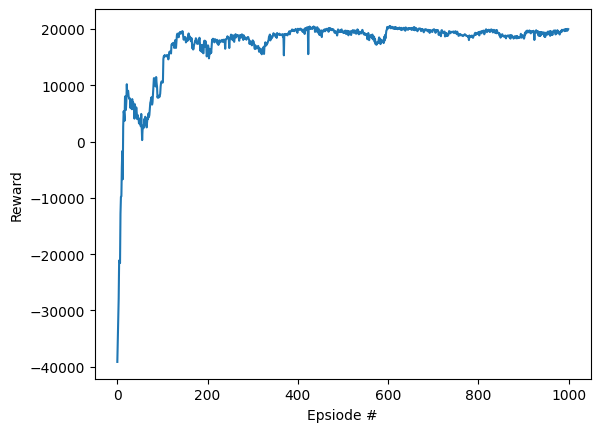

In [11]:
# Defining the Hyperparameters
BUFFER_SIZE = int(4*1e4)
BATCH_SIZE = 256
GAMMA = 0.90
TAU = 1e-3
LR = 2e-4
UPDATE_EVERY = 5

class Agent():    
    def __init__(self, state_size, action_size, seed):        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)        
        #Q- Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(),lr=LR)
        
        # Replay memory 
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE,BATCH_SIZE,seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
        
    def step(self, state, action, reward, next_step, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_step, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step+1)% UPDATE_EVERY
        if self.t_step == 0:
            if len(self.memory)>BATCH_SIZE:
                experience = self.memory.sample()
                self.learn(experience, GAMMA)
        
    def act(self, state, eps = 0):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        #Epsilon -greedy action selction
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
            
    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences
        criterion = torch.nn.MSELoss()
        self.qnetwork_local.train()
        self.qnetwork_target.eval()
        
        predicted_targets = self.qnetwork_local(states).gather(1,actions)
        with torch.no_grad():
            labels_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        labels = rewards + (gamma* labels_next*(1-dones))
        loss = criterion(predicted_targets,labels).to(device)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network #
        self.soft_update(self.qnetwork_local,self.qnetwork_target,TAU)
            
    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1-tau)*target_param.data)
            
class ReplayBuffer:
    
    def __init__(self, action_size, buffer_size, batch_size, seed):        
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experiences = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        
    def add(self,state, action, reward, next_state,done):
        e = self.experiences(state,action,reward,next_state,done)
        self.memory.append(e)
        
    def sample(self):
    
        experiences = random.sample(self.memory,k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        return (states,actions,rewards,next_states,dones)
    
    def __len__(self):
        return len(self.memory)

agent = Agent(state_size=7,action_size=21,seed=0)

def dqn(env, n_episodes= 1000, max_t = 7000, eps_start=1.0, eps_end = 0.01, eps_decay=0.955):
    scores = []
    eps = eps_start
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state,eps)
            next_state,reward,done = env.step(action)
            agent.step(state,action,reward,next_state,done)
            state = next_state
            score += reward
            if done:
                print('episode'+str(i_episode)+':', score)
                scores.append(score)
                break
        eps = max(eps*eps_decay,eps_end)## decrease the epsilon
    return scores

env = InvOptEnv(demand_hist)
scores= dqn(env)

plt.plot(np.arange(len(scores)),scores)
plt.ylabel('Reward')
plt.xlabel('Epsiode #')
plt.show()

Set of HyperParameters tested 4

episode1: -39846.0
episode2: -38471.0
episode3: -40980.0
episode4: -39476.0
episode5: -36972.0
episode6: -38560.0
episode7: -33428.0
episode8: -34800.0
episode9: -35907.0
episode10: -38237.0
episode11: -37726.0
episode12: -35595.0
episode13: -38809.0
episode14: -32307.0
episode15: -34805.0
episode16: -34696.0
episode17: -27047.0
episode18: -31131.0
episode19: -32677.0
episode20: -38182.0
episode21: -27721.0
episode22: -34868.0
episode23: -30531.0
episode24: -30632.0
episode25: -28831.0
episode26: -34638.0
episode27: -32750.0
episode28: -29058.0
episode29: -26709.0
episode30: -30611.0
episode31: -28429.0
episode32: -27987.0
episode33: -26226.0
episode34: -29654.0
episode35: -28270.0
episode36: -25765.0
episode37: -19159.0
episode38: -25128.0
episode39: -27162.0
episode40: -25819.0
episode41: -22266.0
episode42: -24727.0
episode43: -21407.0
episode44: -29057.0
episode45: -24283.0
episode46: -16517.0
episode47: -21548.0
episode48: -24126.0
episode49: -19293.0
episode50: -24833.0
episode51

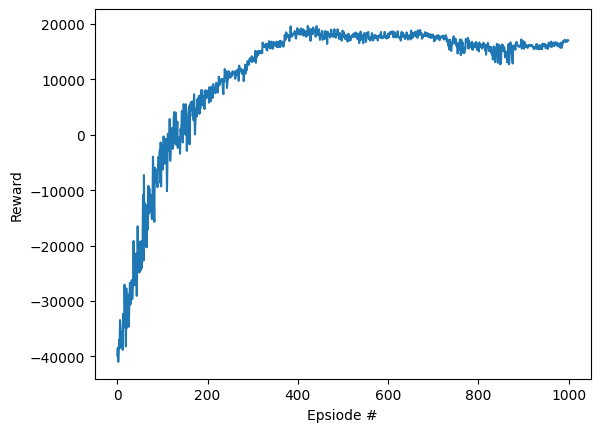

In [12]:
# Defining the Hyperparameters
BUFFER_SIZE = int(5*1e5)
BATCH_SIZE = 128
GAMMA = 0.90
TAU = 1e-3
LR = 1e-4
UPDATE_EVERY = 4

class Agent():    
    def __init__(self, state_size, action_size, seed):        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)        
        #Q- Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(),lr=LR)
        
        # Replay memory 
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE,BATCH_SIZE,seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
        
    def step(self, state, action, reward, next_step, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_step, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step+1)% UPDATE_EVERY
        if self.t_step == 0:
            if len(self.memory)>BATCH_SIZE:
                experience = self.memory.sample()
                self.learn(experience, GAMMA)
        
    def act(self, state, eps = 0):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        #Epsilon -greedy action selction
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
            
    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences
        criterion = torch.nn.MSELoss()
        self.qnetwork_local.train()
        self.qnetwork_target.eval()
        
        predicted_targets = self.qnetwork_local(states).gather(1,actions)
        with torch.no_grad():
            labels_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        labels = rewards + (gamma* labels_next*(1-dones))
        loss = criterion(predicted_targets,labels).to(device)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network #
        self.soft_update(self.qnetwork_local,self.qnetwork_target,TAU)
            
    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1-tau)*target_param.data)
            
class ReplayBuffer:
    
    def __init__(self, action_size, buffer_size, batch_size, seed):        
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experiences = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        
    def add(self,state, action, reward, next_state,done):
        e = self.experiences(state,action,reward,next_state,done)
        self.memory.append(e)
        
    def sample(self):
    
        experiences = random.sample(self.memory,k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        return (states,actions,rewards,next_states,dones)
    
    def __len__(self):
        return len(self.memory)

agent = Agent(state_size=7,action_size=21,seed=0)

def dqn(env, n_episodes= 1000, max_t = 7000, eps_start=1.0, eps_end = 0.01, eps_decay=0.995):
    scores = []
    eps = eps_start
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state,eps)
            next_state,reward,done = env.step(action)
            agent.step(state,action,reward,next_state,done)
            state = next_state
            score += reward
            if done:
                print('episode'+str(i_episode)+':', score)
                scores.append(score)
                break
        eps = max(eps*eps_decay,eps_end)## decrease the epsilon
    return scores

env = InvOptEnv(demand_hist)
scores= dqn(env)

plt.plot(np.arange(len(scores)),scores)
plt.ylabel('Reward')
plt.xlabel('Epsiode #')
plt.show()

Training the DQN Model and Creating Checkpoints

In [7]:
agent = Agent(state_size=7,action_size=21,seed=0)

def dqn(env, n_episodes= 1000, max_t = 10000, eps_start=1.0, eps_end = 0.01, eps_decay=0.90):
    scores = []
    eps = eps_start
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state,eps)
            next_state,reward,done = env.step(action)
            agent.step(state,action,reward,next_state,done)
            state = next_state
            score += reward
            if done:
                print('episode'+str(i_episode)+':', score)
                scores.append(score)
                break

        eps = max(eps*eps_decay,eps_end)
    return scores

env = InvOptEnv(demand_hist)
scores= dqn(env)

plt.plot(np.arange(len(scores)),scores)
plt.ylabel('Reward')
plt.xlabel('Epsiode #')
plt.show()




episode1: -38720.0
episode2: -33668.0
episode3: -25929.0
episode4: -18276.0
episode5: -8444.0
episode6: -3093.0
episode7: -2599.0
episode8: 3789.0
episode9: 7675.0
episode10: 7332.0
episode11: 7869.0
episode12: 9907.0
episode13: 8009.0
episode14: 7410.0
episode15: 8221.0
episode16: 6568.0
episode17: 6190.0
episode18: 5242.0
episode19: 4363.0
episode20: 5525.0
episode21: 3910.0
episode22: 3890.0
episode23: 4038.0
episode24: 3549.0
episode25: 3389.0
episode26: 2600.0
episode27: 2660.0
episode28: 2308.0
episode29: 2575.0
episode30: 1823.0
episode31: 1621.0
episode32: 2008.0
episode33: 1592.0
episode34: 1578.0
episode35: 2285.0
episode36: 1652.0
episode37: 778.0
episode38: 1300.0
episode39: 1178.0
episode40: 1286.0
episode41: 941.0
episode42: 1556.0
episode43: 745.0
episode44: 998.0
episode45: 850.0
episode46: 862.0
episode47: 1104.0
episode48: 697.0
episode49: 1264.0
episode50: 961.0
episode51: 798.0
episode52: 643.0
episode53: 668.0
episode54: 1483.0
episode55: 837.0
episode56: 525.0
epi

KeyboardInterrupt: 

In [13]:
demand_test = []
for k in range(100,200):
    np.random.seed(k)
    demand_future = []
    for i in range(52):
        for j in range(4):
            random_demand = np.random.normal(3, 1.5)
            if random_demand < 0:
                random_demand = 0
            random_demand = np.round(random_demand)
            demand_future.append(random_demand)
        random_demand = np.random.normal(6, 1)
        if random_demand < 0:
            random_demand = 0
        random_demand = np.round(random_demand)
        demand_future.append(random_demand)
        for j in range(2):
            random_demand = np.random.normal(12, 2)
            if random_demand < 0:
                random_demand = 0
            random_demand = np.round(random_demand)
            demand_future.append(random_demand)
    demand_test.append(demand_future)

In [14]:
desired_path = r"C:\Users\snehi\6th Sem Projects\Math Project\model\model.pth"
model = QNetwork(state_size=7,action_size=21,seed=0)
model.load_state_dict(torch.load(desired_path))
model.eval()

profit_RL = []
actions_list = []
invs_list = []

for demand in demand_test:
    env = InvOptEnv(demand)
    env.reset()
    profit = 0
    actions = []
    invs = []
    done = False
    state = env.state
    while not done:
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        with torch.no_grad():
            action_values = model(state)
        action = np.argmax(action_values.cpu().data.numpy())
        actions.append(action)
        next_state, reward, done = env.step(action)
        state = next_state
        invs.append(env.inv_level)
        profit += reward
    actions_list.append(actions)
    invs_list.append(invs)
    profit_RL.append(profit)
RL_mean = np.mean(profit_RL)
print((actions_list[1]))
print((invs_list[1]))
print((profit_RL))
print((demand_test[1]))

[0, 0, 0, 20, 0, 18, 0, 0, 0, 0, 20, 0, 18, 0, 0, 0, 0, 20, 11, 0, 0, 20, 0, 0, 11, 0, 18, 0, 0, 0, 0, 20, 0, 18, 0, 0, 0, 0, 20, 15, 0, 0, 0, 0, 20, 0, 18, 0, 0, 20, 0, 0, 11, 0, 18, 0, 0, 0, 18, 0, 11, 3, 18, 0, 0, 0, 20, 0, 18, 0, 0, 0, 0, 18, 0, 18, 0, 0, 0, 0, 20, 0, 18, 0, 0, 0, 0, 20, 0, 18, 0, 0, 0, 20, 0, 0, 18, 0, 0, 0, 0, 20, 0, 18, 0, 0, 0, 0, 18, 0, 18, 0, 0, 0, 0, 20, 0, 18, 0, 0, 0, 0, 18, 0, 18, 0, 0, 0, 18, 0, 18, 0, 0, 20, 0, 0, 11, 0, 18, 0, 0, 0, 0, 20, 0, 18, 0, 0, 0, 0, 20, 0, 18, 0, 0, 0, 0, 18, 0, 18, 0, 0, 0, 0, 18, 0, 18, 0, 0, 0, 0, 18, 0, 18, 0, 0, 0, 0, 18, 0, 18, 0, 0, 0, 0, 18, 0, 18, 0, 0, 0, 0, 18, 0, 18, 0, 0, 0, 0, 20, 0, 18, 0, 0, 0, 0, 20, 0, 18, 0, 0, 0, 0, 20, 0, 18, 0, 0, 0, 0, 20, 0, 18, 0, 0, 0, 0, 18, 0, 18, 0, 0, 0, 0, 20, 0, 18, 0, 0, 0, 0, 18, 0, 18, 0, 0, 0, 0, 18, 11, 0, 0, 0, 20, 0, 0, 18, 11, 0, 0, 0, 0, 18, 0, 18, 0, 0, 0, 0, 18, 0, 18, 0, 0, 0, 18, 0, 0, 18, 0, 0, 0, 0, 18, 0, 18, 0, 0, 0, 0, 20, 0, 18, 0, 0, 0, 20, 0, 18, 0, 0, 0, 0,

In [7]:
import os

checkpoints_dir = r"C:\Users\snehi\6th Sem Projects\Math Project\model_checkpoints"
model = QNetwork(state_size=7,action_size=21,seed=0)
results = {}

for filename in os.listdir(checkpoints_dir):
    if filename.endswith(".pth"):
        checkpoint_path = os.path.join(checkpoints_dir, filename)
        model.load_state_dict(torch.load(checkpoint_path))
        model.eval()

        profit_RL = []
        actions_list = []
        invs_list = []

        for demand in demand_test:
            env = InvOptEnv(demand)
            env.reset()
            profit = 0
            actions = []
            invs = []
            done = False
            state = env.state
            while not done:
                state = torch.from_numpy(state).float().unsqueeze(0).to(device)
                with torch.no_grad():
                    action_values = model(state)
                action = np.argmax(action_values.cpu().data.numpy())
                actions.append(action)
                next_state, reward, done = env.step(action)
                state = next_state
                invs.append(env.inv_level)
                profit += reward

                env.render(action, reward, filename)
                pygame.display.update()
                print("Updated display")
                clock.tick(5000)  
                pygame.time.delay(7000)
            actions_list.append(actions)
            invs_list.append(invs)
            profit_RL.append(profit)

        results[filename] = {
            "actions_list": actions_list,
            "invs_list": invs_list,
            "profit_RL": profit_RL,
        }

for filename, result in results.items():
    print(f"Actions for checkpoint {filename}: {result['actions_list'][0]}")



Updated display
Updated display
Updated display
Updated display
Updated display
Updated display
Updated display
Updated display
Updated display


: 

: 